In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import pickle
with open('/content/drive/MyDrive/PathVQA/PathVQA/split/qas/train/train_qa.pkl', 'rb') as f:
  qa_train = pickle.load(f)
id = []
for i in range(len(qa_train)):
  id.append(qa_train[i].get('image'))
img_id = [*set(id)]
len(img_id)
qa_train[0]

{'image': 'train_0422',
 'question': 'Where are liver stem cells (oval cells) located?',
 'answer': 'in the canals of hering'}

In [4]:
import pandas as pd
df = pd.DataFrame(qa_train)
df

image                                           question  \
0      train_0422   Where are liver stem cells (oval cells) located?   
1      train_0422  What are stained here with an immunohistochemi...   
2      train_0422  What are bile duct cells and canals of Hering ...   
3      train_0422  Are bile duct cells and canals of Hering stain...   
4      train_0986              What shows dissolution of the tissue?   
...           ...                                                ...   
19750  train_2794                                     Where is this?   
19751  train_2584                         What does this image show?   
19752  train_2584  Does this image show polyarteritis nodosa, kid...   
19753  train_2584  Does cytomegaly show polyarteritis nodosa, kid...   
19754  train_2584                                     Where is this?   

                                     answer  
0                   in the canals of hering  
1      bile duct cells and canals of hering  
2              an immunohistochemical stain  
3                                       yes  
4                   an infarct in the brain  
...                                     ...  
19750                               urinary  
19751                  polyarteritis nodosa  
19752                                   yes  
19753                                    no  
19754                               urinary  

[19755 rows x 3 columns]

In [5]:
import re
from tqdm import tqdm

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
preprocessed_questions = []
for question in tqdm(df['question'].values):
    que = decontracted(question) 
    preprocessed_questions.append(que.lower().strip())
df['question']=preprocessed_questions
df.head(2)

100%|██████████| 19755/19755 [00:00<00:00, 101247.94it/s]


image                                           question  \
0  train_0422   where are liver stem cells (oval cells) located?   
1  train_0422  what are stained here with an immunohistochemi...   

                                 answer  
0               in the canals of hering  
1  bile duct cells and canals of hering

In [6]:
import os 
answer_space = []
for ans in df.answer.to_list():
    answer_space = answer_space + [ans] if "," not in ans else answer_space + ans.replace(" ", "").split(",") 

answer_space = list(set(answer_space))
answer_space.sort()
with open(os.path.join("/content/dataset", "answer_space.txt"), "w") as f:
    f.writelines("\n".join(answer_space))

# Since the actual dataset contains only ~54% of the data for training (very less),
# we produce our own splits for training & evaluation with 80% data being used for training
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.to_csv(os.path.join("/content/dataset", "data_train.csv"), index=None)
test_df.to_csv(os.path.join("/content/dataset", "data_eval.csv"), index=None)

In [7]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 36.8 MB/s 
     |████████████████████████████████| 163 kB 73.1 MB/s 
     |████████████████████████████████| 95 kB 5.5 MB/s 
     |████████████████████████████████| 115 kB 92.5 MB/s 
     |████████████████████████████████| 212 kB 70.1 MB/s 
     |████████████████████████████████| 127 kB 73.4 MB/s 
     |████████████████████████████████| 115 kB 70.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [8]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 36.4 MB/s 
     |████████████████████████████████| 7.6 MB 56.2 MB/s 


In [9]:
i='malignantthymoma'
# if element present then return
# exist otherwise not exist
if i in test_df.answer.to_list():
    print("exist")
else:
    print("not exist")

not exist


In [10]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,            
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

# import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

In [11]:
dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join( "/content/dataset", "data_train.csv"),
        "test": os.path.join("/content/dataset", "data_eval.csv")
    }
)

with open(os.path.join("/content/dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.split(",")[0]) for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-45b342e7249f102c/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer', 'label'],
        num_rows: 15804
    })
    test: Dataset({
        features: ['image', 'question', 'answer', 'label'],
        num_rows: 3951
    })
})

In [12]:
dataset['train']

Dataset({
    features: ['image', 'question', 'answer', 'label'],
    num_rows: 15804
})

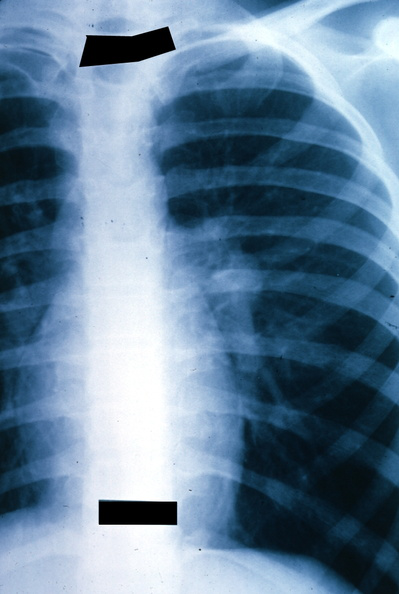

In [13]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join("/content/drive/MyDrive/PathVQA/PathVQA/split", "images/train", data[id]["image"] + ".jpg"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))
    
showExample()

Question:	 what left hilar mass tumor in hilar node?
Answer:		 x-ray chest (Label: 3241)


In [14]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=50,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("/content/drive/MyDrive/PathVQA/PathVQA/split/images/train", image_id + ".jpg")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image']
                if isinstance(raw_batch_dict, dict) else
                [i['image'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

In [15]:
class MultimodalVQAModel(nn.Module):
    def __init__(self,  pretrained_text_name, pretrained_image_name, num_labels=len(answer_space), intermediate_dim=512, dropout=0.5):
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        
	# Pretrained transformers for text & image featurization 
        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)
		
	# Fusion layer for cross-modal interaction
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
	# Fully-connected classifier
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)
        
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

In [16]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    # Initialize the correct text tokenizer and image feature extractor, and use them to create the collator
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)
    multimodal_collator = MultimodalCollator(tokenizer=tokenizer, preprocessor=preprocessor)
  
    # Initialize the multimodal model with the appropriate weights from pretrained models
    multimodal_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    
    return multimodal_collator, multimodal_model

In [17]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a) 
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score 

In [18]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

# Function to compute all relevant performance metrics, to be passed into the trainer
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

In [19]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [20]:
import torch
torch.cuda.empty_cache()
multi_args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345, 
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Since models are large, save only the last 3 checkpoints at any given time while training 
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=10,
    learning_rate=1e-5,
    weight_decay=1e-4,
    gradient_accumulation_steps=2,
    dataloader_num_workers=4,
    load_best_model_at_end=True,
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the actual collator and multimodal model
collator, model = createMultimodalVQACollatorAndModel("bert-base-uncased", "google/vit-base-patch16-224-in21k")

# Initialize the trainer with the dataset, collator, model, hyperparameters and evaluation metrics
multi_trainer = Trainer(
	model,
	multi_args,
	train_dataset=dataset['train'],
	eval_dataset=dataset['test'],
	data_collator=collator,
	compute_metrics=compute_metrics
)

# Start the training loop
train_multi_metrics = multi_trainer.train()

# Run the model on the evaluation set to obtain final metrics
eval_multi_metrics = multi_trainer.evaluate()

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 15804
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 2470
  Number of trainable parameters = 198337481


***** Running Evaluation *****
  Num examples = 3951
  Batch size = 32
Saving model checkpoint to checkpoint/checkpoint-100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 3951
  Batch size = 32
Saving model checkpoint to checkpoint/checkpoint-200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 3951
  Batch size = 32
Saving model checkpoint to checkpoint/checkpoint-300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 3951
  Batch size = 32
Saving model checkpoint to checkpoint/checkpoint-400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Deleting older checkpoint [checkpoint/checkpoint-100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 3951
  Batch size = 32
Saving model checkpoint to checkpoint/checkpoint-500
Trainer.model is 

In [22]:
import transformers
def loadAnswerSpace() -> List[str]:
    with open(os.path.join("/content/dataset", "answer_space.txt")) as f:
        answer_space = f.read().splitlines()
    return answer_space

def tokenizeQuestion(text_encoder, question, device) -> Dict:
    tokenizer = transformers.AutoTokenizer.from_pretrained(text_encoder)
    encoded_text = tokenizer(
        text=[question],
        padding='longest',
        max_length=50,
        truncation=True,
        return_tensors='pt',
        return_token_type_ids=True,
        return_attention_mask=True,
    )
    return {
        "input_ids": encoded_text['input_ids'].to(device),
        "token_type_ids": encoded_text['token_type_ids'].to(device),
        "attention_mask": encoded_text['attention_mask'].to(device),
    }

def featurizeImage(image_encoder, img_path, device) -> Dict:
    featurizer = transformers.AutoFeatureExtractor.from_pretrained(image_encoder)
    processed_images = featurizer(
            images=[Image.open(img_path).convert('RGB')],
            return_tensors="pt",
        )
    return {
        "pixel_values": processed_images['pixel_values'].to(device),
    }

  
question = "What does the image show?"
img_path = "/content/drive/MyDrive/PathVQA/PathVQA/split/images/train/train_2584.jpg"
  
# Load the vocabulary of all answers
answer_space = loadAnswerSpace()

# Tokenize the question & featurize the image
question = question.lower().replace("?", "").strip()                    # Remove the question mark (if present) & extra spaces before tokenizing
tokenized_question = tokenizeQuestion("bert-base-uncased", question, device)
featurized_img = featurizeImage("google/vit-base-patch16-224-in21k", img_path, device)

# Load the model checkpoint (for 5 epochs, final checkpoint should be checkpoint-1500)
model = MultimodalVQAModel(
    pretrained_text_name="bert-base-uncased",
    pretrained_image_name="google/vit-base-patch16-224-in21k",
    num_labels=len(answer_space)
)
#/content/checkpoint/checkpoint-2400/pytorch_model.bin
checkpoint = os.path.join("/content/checkpoint", "checkpoint-2100", "pytorch_model.bin")
model.load_state_dict(torch.load(checkpoint))
model.to(device)

model.eval()

# Obtain the prediction from the model
input_ids = tokenized_question["input_ids"].to(device)
token_type_ids = tokenized_question["token_type_ids"].to(device)
attention_mask = tokenized_question["attention_mask"].to(device)
pixel_values = featurized_img["pixel_values"].to(device)
output = model(input_ids, pixel_values, attention_mask, token_type_ids)

# Obtain the answer from the answer space
preds = output["logits"].argmax(axis=-1).cpu().numpy()
answer = answer_space[preds[0]]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/vocab.txt
loading file to

In [23]:
print(answer)

lung


In [24]:
sample = collator(dataset["test"][2500:2506])

input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)
preds = output["logits"].argmax(axis=-1).cpu().numpy()
preds

array([1286, 3270, 1650, 2501, 1278, 3270])

*********************************************************


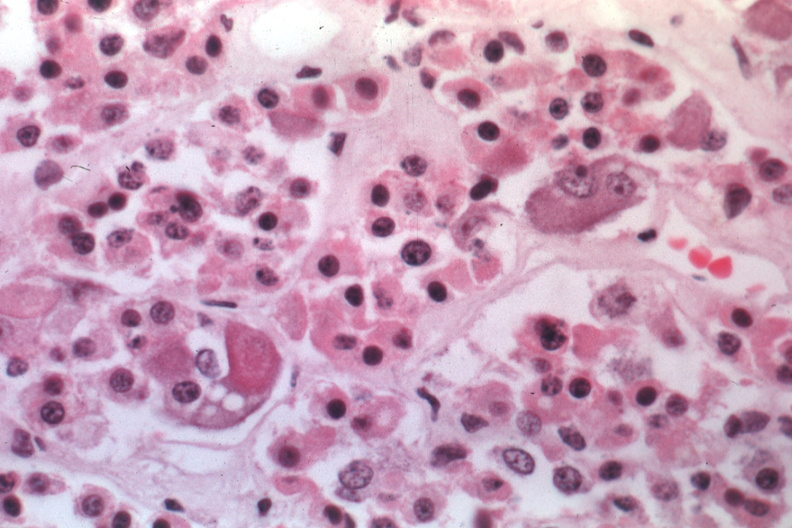

Question:	 what is present ?
Answer:		 crookes cells (Label: 738)
Predicted Answer:	 hematologic
*********************************************************
*********************************************************


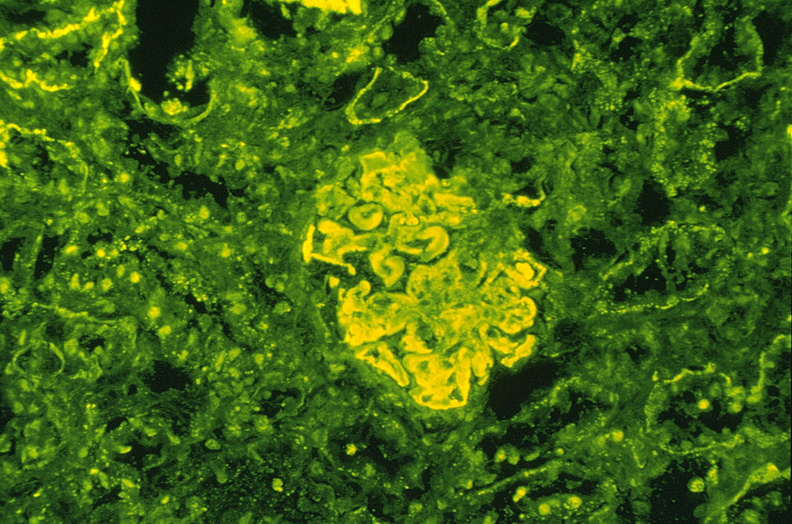

Question:	 is urinary present?
Answer:		 yes (Label: 3270)
Predicted Answer:	 yes
*********************************************************
*********************************************************


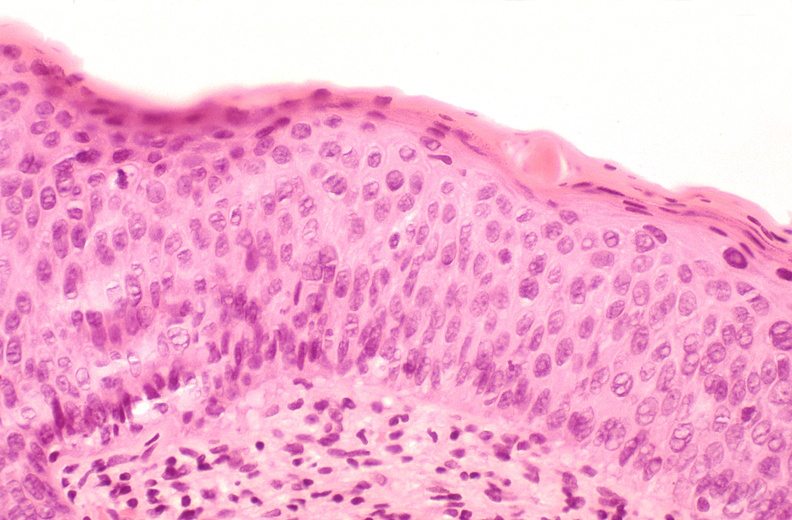

Question:	 what does this image show?
Answer:		 cervix (Label: 577)
Predicted Answer:	 lung
*********************************************************
*********************************************************


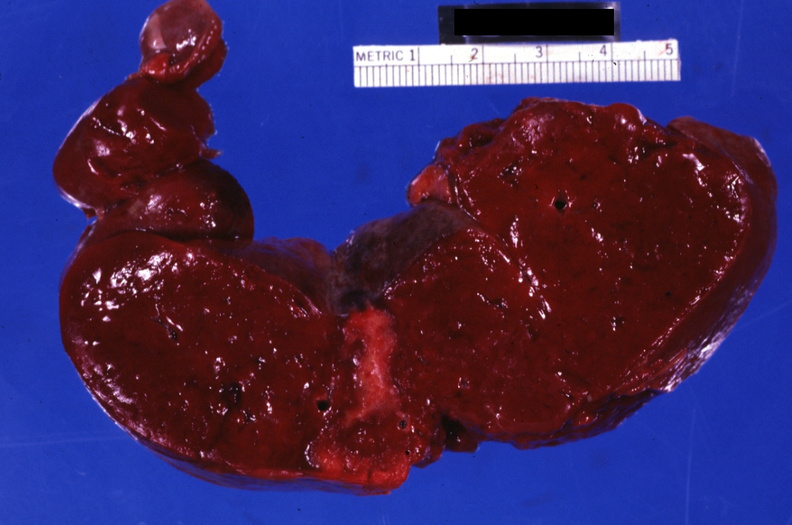

Question:	 where is this part in?
Answer:		 spleen (Label: 2501)
Predicted Answer:	 spleen
*********************************************************
*********************************************************


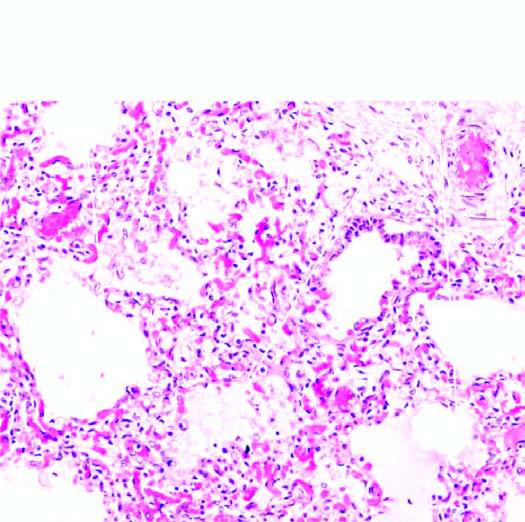

Question:	 what is there of septal walls while the air spaces contain pale oedema fluid and a few red cells?
Answer:		 congestion (Label: 712)
Predicted Answer:	 heart
*********************************************************
*********************************************************


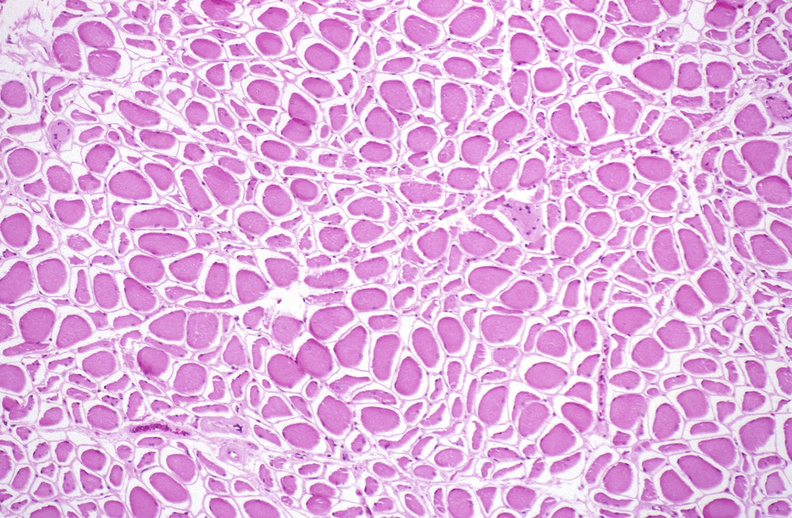

Question:	 does this image show skeletal muscle atrophy?
Answer:		 yes (Label: 3270)
Predicted Answer:	 yes
*********************************************************


In [25]:
for i in range(2500, 2506):
    print("*********************************************************")
    showExample(train=False, id=i)
    print("Predicted Answer:\t", answer_space[preds[i-2500]])
    print("*********************************************************")

In [37]:
eval_multi_metrics = multi_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3951
  Batch size = 32
